In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

import sys
import os
import sqlite3

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, RFE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

tf.random.set_seed(42)
np.random.seed(42)

In [8]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [9]:
di = 'SPEI'
di_scale = 3

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
]

In [10]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [11]:
# selected_stations = ['Ramsar', 'Nowshahr', 'Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht', 'Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']
# selected_stations = ['Ramsar', 'Nowshahr']
selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [12]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [14]:
cols_to_lag = [
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM'
]

for lag in range(1, 13):
    for col in cols_to_lag:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

/tmp/ipykernel_140056/250578046.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_140056/250578046.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_140056/250578046.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [15]:
for col in cols_to_lag:
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    df[f'{col}_roll_mean_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    df[f'{col}_roll_std_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).std())
    df[f'{col}_roll_mean_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).mean())
    df[f'{col}_roll_std_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).std())
    df[f'{col}_roll_mean_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
    df[f'{col}_roll_std_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).std())


/tmp/ipykernel_140056/1487553917.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
/tmp/ipykernel_140056/1487553917.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
/tmp/ipykernel_140056/1487553917.py:4: PerformanceWarning: DataFrame is highly fragmented.  Th

In [16]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y_raw = df[f'{di}_{di_scale}_Class']

# y = df[f'{di}_{di_scale}_Class']

# Stacking Meta-Model


Class labels encoded sequentially.

--- Scaling Data ---

--- Performing Automatic Feature Selection with RFECV ---
Optimal number of features found by RFECV: 26
RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                       random_state=42),
      min_features_to_select=5, n_jobs=-1, scoring='f1_macro')
Capping features to 20.
Final selected features: ['GPM_SPEI_3', 'ERA5_SPEI_3', 'GPM_SPEI_3_lag_1', 'PCI_GPM_lag_1', 'CI_GPM_lag_1', 'PCI_GPM_lag_2', 'GPM_SPEI_3_lag_9', 'ERA5_SPEI_3_lag_9', 'TERRACLIMATE_Precipitation_roll_std_9', 'GPM_SPEI_3_roll_mean_3', 'GPM_SPEI_3_roll_std_12', 'ERA5_SPEI_3_roll_mean_3', 'ERA5_SPEI_3_roll_std_6', 'NDVI_roll_std_6', 'PCI_GPM_roll_mean_3', 'TCI_roll_mean_3', 'TCI_roll_mean_6', 'TCI_roll_std_9', 'VHI_roll_mean_3', 'CI_GPM_roll_mean_3']

Balancing training data with SMOTE...

--- Training Base Models to Create Meta-Features ---
Training r

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-22 11:28:35.863334: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,023 (7.90 KB)

 Trainable params: 2,023 (7.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3543 - loss: 1.8517 - val_accuracy: 0.3328 - val_loss: 2.1198
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6103 - loss: 1.3412 - val_accuracy: 0.3345 - val_loss: 1.9760
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7265 - loss: 1.0079 - val_accuracy: 0.3345 - val_loss: 1.7606
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.8033 - val_accuracy: 0.3345 - val_loss: 1.6296
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.6876 - val_accuracy: 0.3345 - val_loss: 1.5937
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8303 - loss: 0.6090 - val_accuracy: 0.3345 - val_loss: 1.5478
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8479 - loss: 0.5472 - val_accuracy: 0.3345 - val_loss: 1.5315
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.5209 - val_accuracy: 0.3345 - v

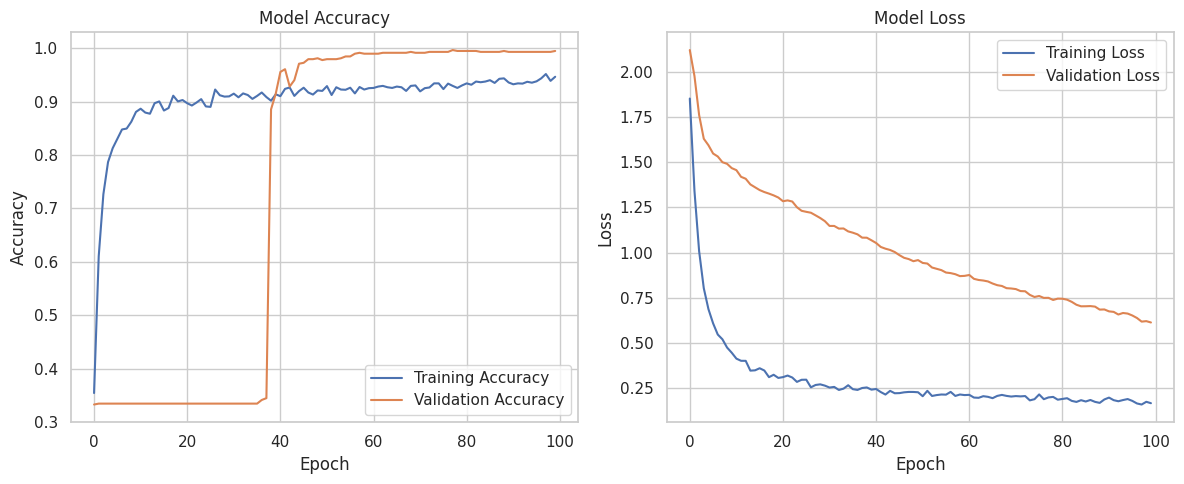

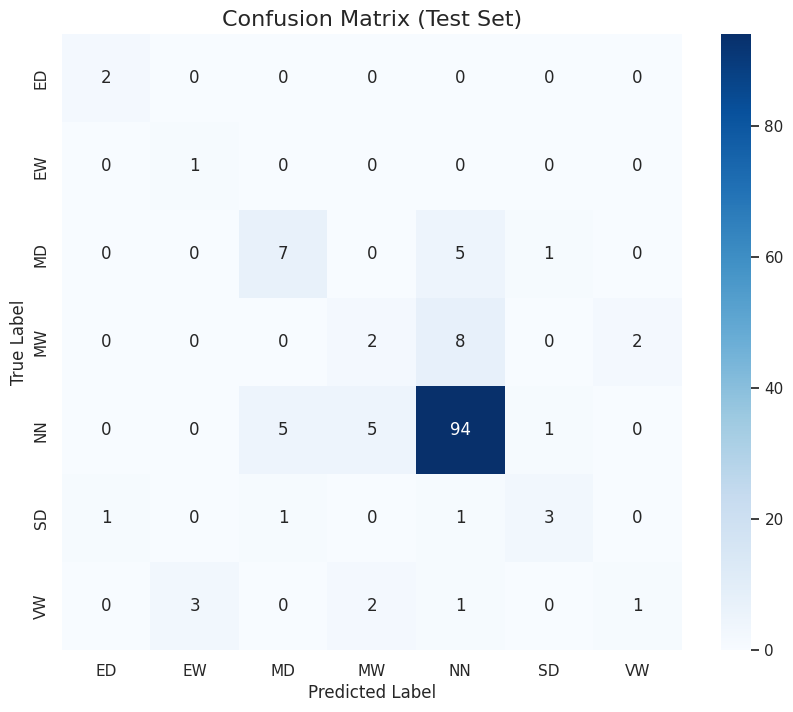


--- Evaluating and Visualizing Training Set Performance ---
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step

Classification Report (Training Set):
              precision    recall  f1-score   support

          ED       1.00      1.00      1.00       418
          EW       1.00      1.00      1.00       418
          MD       1.00      1.00      1.00       418
          MW       1.00      1.00      1.00       418
          NN       1.00      1.00      1.00       418
          SD       1.00      1.00      1.00       418
          VW       1.00      0.99      1.00       418

    accuracy                           1.00      2926
   macro avg       1.00      1.00      1.00      2926
weighted avg       1.00      1.00      1.00      2926



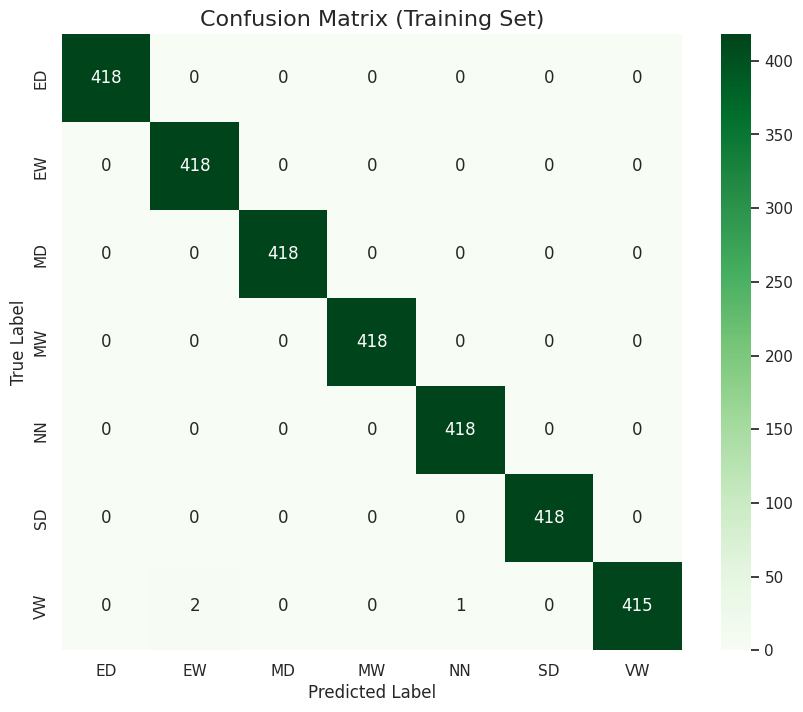

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# کتابخانه های مورد نیاز برای مدل های مختلف و Stacking
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
# StandardScaler برای استانداردسازی داده ها اضافه شد
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, RFE

# کتابخانه های مورد نیاز برای شبکه عصبی
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2


# برای اطمینان از تکرارپذیری نتایج
tf.random.set_seed(42)
np.random.seed(42)


# --- 3. Data Cleaning, Encoding, and Splitting ---
class_counts = y_raw.value_counts()
classes_to_remove = class_counts[class_counts < 2].index
if not classes_to_remove.empty:
    print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
    indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
    X = X.drop(indices_to_remove)
    y_raw = y_raw.drop(indices_to_remove)
    print(f"New data shape after removing rare classes: {X.shape}")

encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
print("\nClass labels encoded sequentially.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 4. Data Scaling ---
print("\n--- Scaling Data ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. Automatic Feature Selection ---
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 20

selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=5, n_jobs=-1)
# انتخاب ویژگی روی داده های مقیاس شده انجام می شود
selector_cv = selector_cv.fit(X_train_scaled, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")
print(selector_cv)

if optimal_n_features > max_features_cap:
    print(f"Capping features to {max_features_cap}.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train_scaled, y_train)
else:
    selector = selector_cv

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)


# این خط نام ستون‌های انتخاب شده را استخراج می‌کند
selected_features = X_train.columns[selector.support_]

# این خط نام‌ها را در خروجی چاپ می‌کند
print("Final selected features:", list(selected_features))

# --- 6. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = pd.Series(y_train).value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# --- 7. Train Base Models and Create Meta-Features ---
print("\n--- Training Base Models to Create Meta-Features ---")

# تعریف مدل های پایه (Pipeline ها برای SVC و KNN حذف شدند)
base_models = {
    'rf': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1),
    'cat': CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0),
    'xgb': XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1),
    'svc': SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'gnb': GaussianNB()
}

# آموزش مدل های پایه و گرفتن پیش بینی های آنها به عنوان ویژگی های جدید
meta_X_train_list = []
meta_X_test_list = []

for name, model in base_models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    # گرفتن پیش بینی های احتمالاتی به عنوان ویژگی
    train_preds = model.predict_proba(X_train_resampled)
    test_preds = model.predict_proba(X_test_selected)
    meta_X_train_list.append(train_preds)
    meta_X_test_list.append(test_preds)

# ترکیب پیش بینی ها برای ساخت دیتاست متا
meta_X_train = np.concatenate(meta_X_train_list, axis=1)
meta_X_test = np.concatenate(meta_X_test_list, axis=1)
print(f"Meta-features created. Train shape: {meta_X_train.shape}, Test shape: {meta_X_test.shape}")


# --- 8. Build, Compile, and Train the Neural Network Meta-Model ---
print("\n--- Building and Training the Neural Network Meta-Model ---")

n_classes = len(encoder.classes_)

# ساخت مدل Sequential
nn_model = Sequential()
nn_model.add(Dense(32, input_dim=meta_X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(n_classes, activation='softmax'))

# کامپایل کردن مدل
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.summary()

# آموزش مدل
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = nn_model.fit(
    meta_X_train,
    y_train_resampled,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # استفاده از بخشی از داده های آموزشی برای اعتبارسنجی
    callbacks=[early_stopping],
    verbose=1
)

# --- 9. Prediction and Evaluation ---
print("\n--- Evaluating the Final Neural Network Model ---")
y_pred_probs = nn_model.predict(meta_X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# برگرداندن برچسب های عددی به رشته ای برای گزارش
y_test_labels = encoder.inverse_transform(y_test)
y_pred_labels = encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels)

print("\n--- Final Model Evaluation Metrics (Neural Network Ensemble) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(report)

# --- 10. Visualization ---
sns.set_theme(style="whitegrid")

# الف) نمودار دقت و خطا در طول آموزش
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# ب) ماتریس درهم ریختگی برای داده های آزمون
cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- 11. Visualization and Report for Training Set ---
print("\n--- Evaluating and Visualizing Training Set Performance ---")

# پیش بینی روی داده های آموزشی برای مقایسه
y_train_pred_probs = nn_model.predict(meta_X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# برگرداندن برچسب های عددی به رشته ای برای گزارش
y_train_labels = encoder.inverse_transform(y_train_resampled)
y_train_pred_labels = encoder.inverse_transform(y_train_pred)

# چاپ گزارش طبقه‌بندی برای داده های آموزشی
print("\nClassification Report (Training Set):")
report_train = classification_report(y_train_labels, y_train_pred_labels)
print(report_train)

# ج) ماتریس درهم ریختگی برای داده های آموزشی
cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Training Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()